### __1. Refreshing our ideas:__
<font size=3>

In the previous notebook, we learned that weights and biases are adjusted by an __optimizer__ algorithm (_e.g._, the SGD method), and this optimizer depends on the gradient of the loss function, computed by the __backpropagation algorithm__.

Some other optimizers are more robust and accurate in the field. Check the [Keras' optimizer list](https://keras.io/api/optimizers/); we will use them in the following deep learning hands-on.

<br>

We saw that the loss function gradient given by
$$
    \vec\nabla\mathcal L = \left(\frac{\partial\mathcal L}{\partial W_l^{ij}},\, \frac{\partial\mathcal L}{\partial b_l^i}\right) \, ,
$$
is computed via backpropagation algorithm,
\begin{align}
     \frac{\partial\mathcal L}{\partial W_l^{ij}} &= \gamma_l^i\,a_{l-1}^j \, , \\
     \frac{\partial\mathcal L}{\partial b_l^i} &= \gamma_l^i \, ,\\
\end{align}
where
\begin{align}
    \gamma_l^i &= 
    \begin{bmatrix}
        \dfrac{\partial\mathcal L}{\partial a_l^i}\,\sigma'_l\left(c^i_l\right) \, ,\quad l = L \\
        \gamma_{l+1}^k\,W_{l+1}^{ki}\,\sigma'_l\left(c^i_l\right) \, ,\quad l \neq L
     \end{bmatrix} \, .
\end{align}

In the middle of this beautiful piece of math, there is a problem about which we must be cautious: the activation function derivative hides the possibility of a __vanishing gradient problem__!

### __2. The vanishing gradient problem:__
<font size=3>

Let's use the sigmoid activation function to understand this issue. Figure 1 shows the sigmoid (in blue) and its derivative (in orange). In the code cell, there is a variable $\mathtt x_0$, which we can see as the vertical dashed line. The values of $\sigma(x)$ and $\sigma'(x)$ at $\mathtt x_0$ are printed above the plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

σ(7.5) = 0.9994
σ'(7.5) = 0.0006


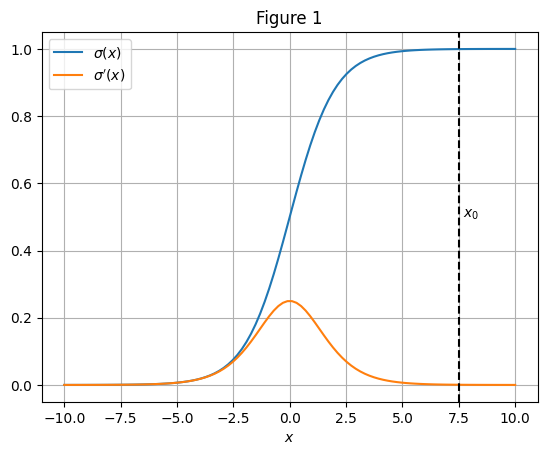

In [2]:
x0 = 7.5

x = np.linspace(-10, 10, 100)

σ = lambda x: 1/(1 + np.exp(-x))
dσ = lambda x: (1 - σ(x))*σ(x)

print(f"σ({x0}) = {σ(x0):.4f}")
print(f"σ'({x0}) = {dσ(x0):.4f}")

plt.title("Figure 1")
plt.plot(x, σ(x), label=r"$\sigma(x)$")
plt.plot(x, dσ(x), label=r"$\sigma'(x)$")
plt.axvline(x=x0, ls='--', c='black')
plt.text(x0+0.2, 0.5, r"$x_0$")
plt.xlabel(r"$x$")
plt.legend()
plt.grid()
plt.show()

<font size=3>

By changing the variable $\mathtt x_0$, $\sigma'(x)$ goes to zero as the neuron gets more activated. $\sigma'(x)$ appears as the argument of the vector $\gamma_l^i$, and consequently, contributes directly to the gradient of the loss function (check the math above). If $\sigma' = 0$, we won't have parameter adjustment in $\vec\omega \rightarrow \vec\omega - \eta\,\vec\nabla\mathcal L$ (please, think about using the equations above). However, for $\sigma' \approx 0$, we still have gradient descent but it will take time to optimize the loss function. 

In fact, the choice of activation functions determines the _"convergence speed"_ of the gradient descent, and so we have to be aware of their derivative functions. In a neural architecture stuffed with sigmoid activation functions, the backpropagation algorithm can lead to $\vec\nabla\mathcal L \rightarrow 0$ and __no__ parameter adjustment is done. This issue is called the __vanishing gradient problem__.

<br>

So let's make a illustrative example to see how vanishing gradient happens.
<center>
<img src="../figs/block_net.png" width="230"/>
</center>

Considering the neural architecture above, we can write _backwardly_ the contributions of $\partial\mathcal L/\partial W_l^{ij}$ from each layer as 
\begin{align}
    l &= 3:\quad \frac{\partial \mathcal L}{\partial W_3^{ij}} = \gamma_3^i\,a_2^j \, ;\quad \gamma_3^i = \frac{\partial \mathcal L}{\partial a_3^i}\,\sigma'_3(c_3^i) \, ,\\
    l &= 2:\quad \frac{\partial \mathcal L}{\partial W_2^{kl}} = \gamma_2^k\,a_1^l \, ;\quad \gamma_2^k = \gamma_3^i\,W_3^{ik}\,\sigma'_2(c_2^k) \, ,\\
    l &= 1:\quad \frac{\partial \mathcal L}{\partial W_1^{mn}} = \gamma_1^m\,a_0^n \, ;\quad \gamma_1^m = \gamma_2^k\,W_2^{km}\,\sigma'_1(c_1^m) \, .
\end{align}

If in the layer $l = 3$ the neurons fire up the $\sigma'_3 = 0.0006$, for example, this value appears in the layer $l = 2$ as $\gamma_3^i$. If again, the $\sigma_2$ is activated, its derivative can be $\sigma'_2 = 0.0002$, which results in a very small number for $\gamma_2^k = (0.0006)(0.0002)\,W_3^{ik} \sim 10^{-7}$. And so for a $\sigma'_1 = 0.005$, $\gamma_1^m \sim 10^{-10}$. Therefore
$$
    W_3^{mn} \rightarrow W_3^{mn} - \eta\,\left<\cancelto{0}{\frac{\partial\mathcal L}{\partial W_3^{mn}}}\right>_m \, ,
$$
the gradient __vanishes__, and __no update__ is done in the parameters $W_3^{mn}$.

<br>

So, how to solve this issue??? Here, we will learn two methods: i) by using the activation function __ReLU__ in the hidden layers, and ii) applying the __normalization layer__.

#### __2.1 The Rectified Linear Unit (ReLU) activation function__:
<font size=3>

The __ReLU__ activation function, given by $\sigma(x) = \max(0, x)$, is a solution for vanishing gradient since its derivative is the Heaviside step function, $\sigma'(x) = 1\, ,\; x \geq 0\, ;\; 0\, ,\; x < 0$ (see Figure 2). Thus, when the neuron is activated, we guarantee gradient descent once $\sigma'(x) \rightarrow 1$.  

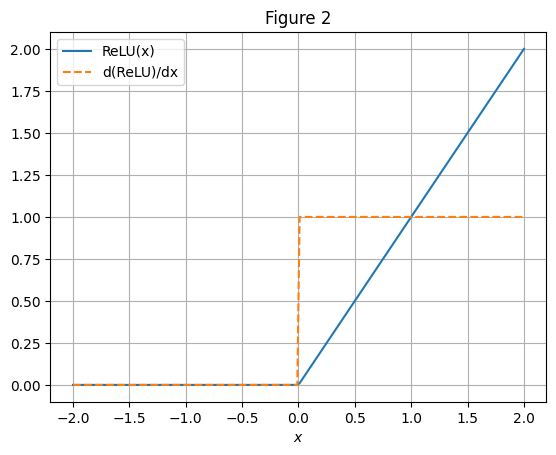

In [3]:
x = np.linspace(-2, 2, 200)

relu = np.maximum(0, x)

H = np.heaviside(x, 0.0)

plt.title("Figure 2")
plt.plot(x, relu, label="ReLU(x)")
plt.plot(x, H, '--', label="d(ReLU)/dx")
plt.xlabel(r"$x$")
plt.legend()
plt.grid()
plt.show()


<font size=3>

Do we still need to make normalization of the data as _feature engineering_ (data pre-processing) since $\mathrm{ReLU} \in [0\,, +\infty]$? Yes, it's still a good ML practice since the weights arrays are inicialized at random (by [Xavier inicialization](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)) in an interval $\sim [-1\,, +1]$. This results in better feature extraction when the numbers are in closer magnitude order.

After ReLU's success in the DL community, other versions of activation functions with good derivative behavior were made, such as __LeakyReLU__, __ELU__, __GELU__, and __SELU__. Check this [activation function list](https://en.wikipedia.org/wiki/Activation_function). 

What of those do we have to use?! \
Calm down! In this course, we will get the feeling by working on examples.

#### __2.2 The normalization layer__:
<font size=3>

The __normalization layer__ prevents vanishing gradient because it ajusts the layer $\vec a_l$'s mean $\mu \rightarrow 0$ and its standard deviation $\sigma \rightarrow 1$, such as
$$
    \hat a_l^i = \gamma_l \frac{a_l^i-\mu}{\sqrt{\sigma^2 + \epsilon}} + \beta_l \, ,
$$
where $\gamma$ and $\beta$ are parameters to be optimized by gradient descent (such as weights and biases) for $\mathbb E\left[\hat a_l^i\right] \approx 0$ and $\mathbb{Var}\left[\hat a_l^i\right] \approx 1$. The hyperparameter $\epsilon$ is a small scalar defined to avoid division by zero (check the [pioneer paper](https://arxiv.org/pdf/1502.03167v3)).

In Keras, the [batch-nomalization layer](https://keras.io/api/layers/normalization_layers/batch_normalization/) is implemented as following.
```python
    x = layers.Dense(42, activation="relu")(x)
    x = layers.BacthNormalization()(x)
```
<br>
<br>

__Questions:__
 * Do we still need to normalize the data during feature engineering? Not necessarily, but you can optimize faster if you help the model with a previous normalization.
 * Why use it? It makes the optimization faster by adjusting only two parameters $(\gamma_l,\, \beta_l)$, instead of changing the magnitude of $\left(W_l^{ij},\,b_l^i\right)$. 
 * Why don't use it? When we use the normalization layer, we get two new parameters by layer. It's good DL practice to build a simple model with as few parameters as possible. Remember [Occam's razor](https://en.wikipedia.org/wiki/Occam%27s_razor): _"The simplest explanation is usually the best one"_.
